
# Hydrogeophysical modeling

Coupled hydrogeophysical modeling example. This essentially represents the
forward modeling step of the example presented in section 3.2 of the [pyGIMLi
paper](http://www.sciencedirect.com/science/article/pii/S0098300417300584/pdfft?md5=44253eaacd5490e3fb32210671672496&pid=1-s2.0-S0098300417300584-main.pdf).


In [1]:
import numpy as np

import pygimli as pg
import pygimli.meshtools as mt
import pygimli.physics.ert as ert
import pygimli.physics.petro as petro
from pygimli.physics import ERTManager

Create geometry definition for the modeling domain



(<Axes: >, None)

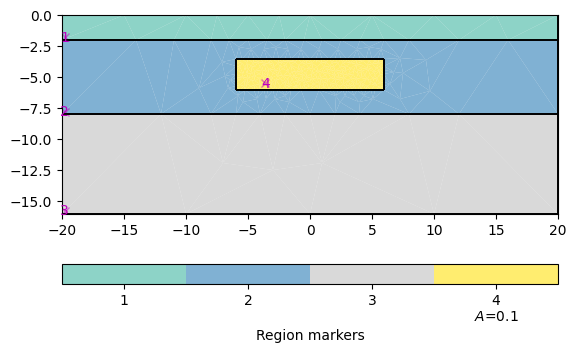

In [2]:
world = mt.createWorld(start=[-20, 0], end=[20, -16], layers=[-2, -8],
                       worldMarker=False)

# Create a heterogeneous block
block = mt.createRectangle(start=[-6, -3.5], end=[6, -6.0], marker=4,
                           boundaryMarker=10, area=0.1)

# Merge geometrical entities
geom = world + block
pg.show(geom, boundaryMarker=True)

Create a mesh from the geometry definition



(<Axes: >, None)

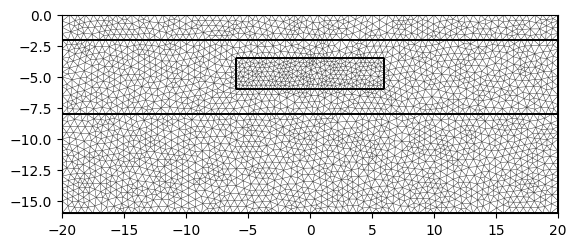

In [3]:
mesh = mt.createMesh(geom, quality=32, area=0.2, smooth=[1, 10])
pg.show(mesh)

Fluid flow in a porous medium of slow non-viscous and non-frictional hydraulic
movement is governed by Darcy's Law according to:

\begin{align}K^{-1}\mathbf{v} + \nabla p & = 0 \\
   \nabla \cdot \mathbf{v} & = 0\\
   \text{leading}\,\,\text{to}\,\,
   \nabla\cdot(K \nabla p) & = 0 \quad \text{on} \quad\Omega\end{align}

We begin by defining isotropic values of hydraulic conductivity $K$ and
mapping these to each mesh cell:



(<Axes: >, <matplotlib.colorbar.Colorbar at 0x7fcd818bbaf0>)

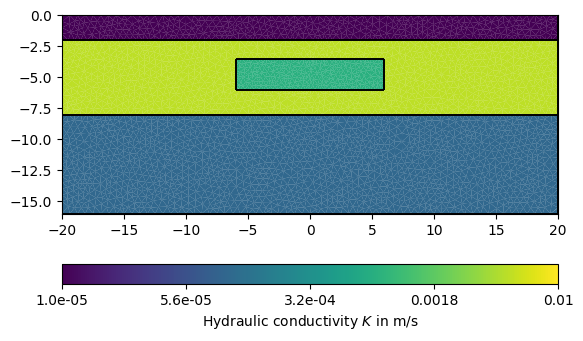

In [4]:
# Map regions to hydraulic conductivity in $m/s$
kMap = [[1, 1e-8], [2, 5e-3], [3, 1e-4], [4, 8e-4]]

# Map conductivity value per region to each cell in the given mesh
K = pg.solver.parseMapToCellArray(kMap, mesh)

pg.show(mesh, data=K, label='Hydraulic conductivity $K$ in m$/$s', cMin=1e-5,
        cMax=1e-2, logScale=True, grid=True)

The problem further boundary conditions of the hydraulic potential. We use
$p=p_0=0.75$ m on the left and $p=0$ on the right boundary of the modelling
domain, equaling a hydraulic gradient of 1.75%.



In [5]:
# Dirichlet conditions for hydraulic potential
left = 0.75
right = 0.0
pBound = {"Dirichlet": {1: left, 2: left, 3: left, 5: right, 6: right, 7: right}}

We can now call the finite element solver with the generated mesh, hydraulic
conductivity and the boundary condition. The sought hydraulic velocity
distribution can then be calculated as the gradient field of
$\mathbf{v}=-\nabla p$ and visualized using the generic `pg.show()` function.



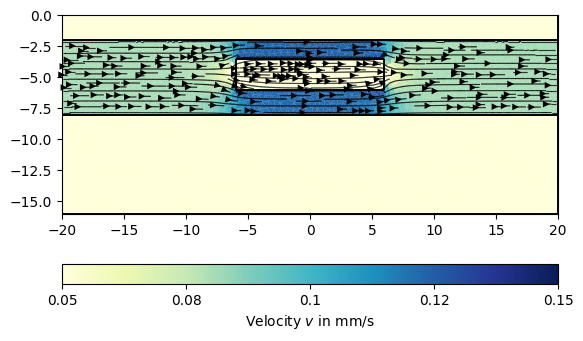

In [6]:
# Solve for hydraulic potential
p = pg.solver.solveFiniteElements(mesh, a=K, bc=pBound)

# Solve velocity as gradient of hydraulic potential
vel = -pg.solver.grad(mesh, p) * np.asarray([K, K, K]).T

ax, _ = pg.show(mesh, data=pg.abs(vel) * 1000, cMin=0.05, cMax=0.15,
                label='Velocity $v$ in mm$/$s', cMap='YlGnBu', hold=True)
ax, _ = pg.show(mesh, data=vel, ax=ax, color='k', linewidth=0.8, dropTol=1e-5,
                hold=True)

In the next step, we use this velocity field to simulate the dynamic movement
of a particle (e.g., salt) concentration $c(\mathbf{r}, t)$ in the aquifer
by using the advection-diffusion equation:

\begin{align}\frac{\partial c}{\partial t} = \underbrace{\nabla\cdot(D \nabla
   c)}_{\text{Diffusion / Dispersion}} - \underbrace{\nabla \cdot
   (\mathbf{v}\nabla c)}_{\text{Advection}} + S\end{align}



In [7]:
S = pg.Vector(mesh.cellCount(), 0.0)

# Fill injection source vector for a fixed injection position
sourceCell = mesh.findCell([-19.1, -4.6])
S[sourceCell.id()] = 1.0 / sourceCell.size()  # g/(l s)

We define a time vector and common velocity-depending dispersion coefficient
$D = \alpha |\mathbf{v}|$ with a dispersivity $\alpha=1\cdot10^{-2}$ m.
We solve the advection-diffsuion equation on the equation level with the finite
volume solver, which results in a particle concentration :math:`c(\mathbf{r},t)$
(in g/l) for each cell center and time step.



/home/jcmefra/anaconda3/envs/pg/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:395: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


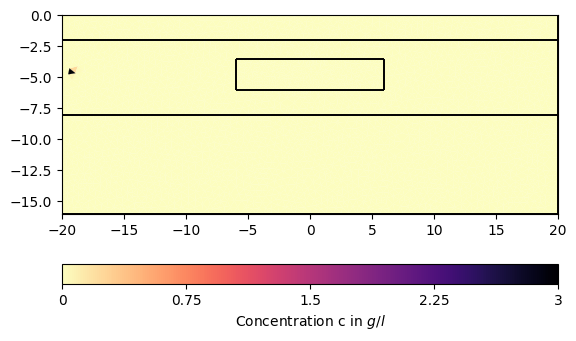

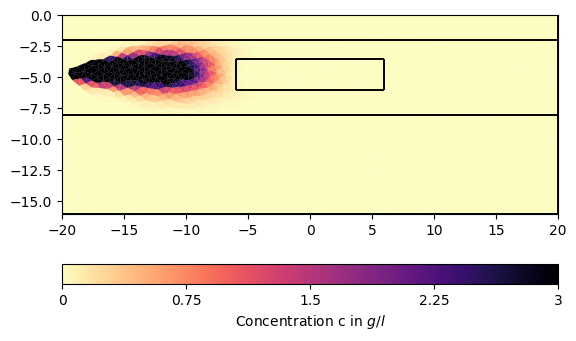

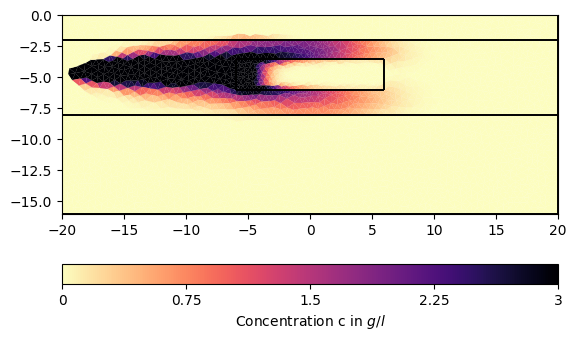

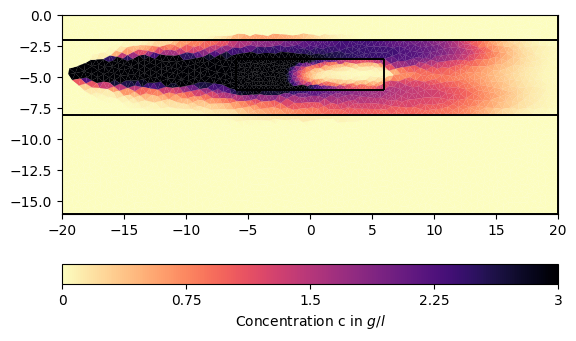

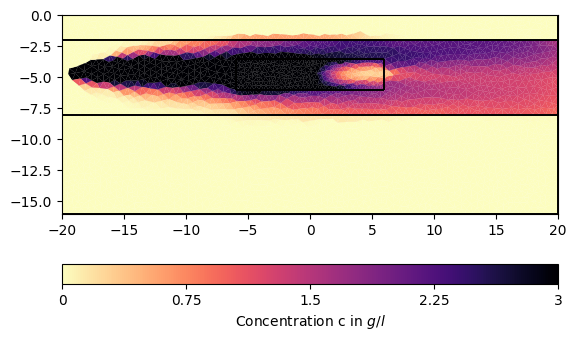

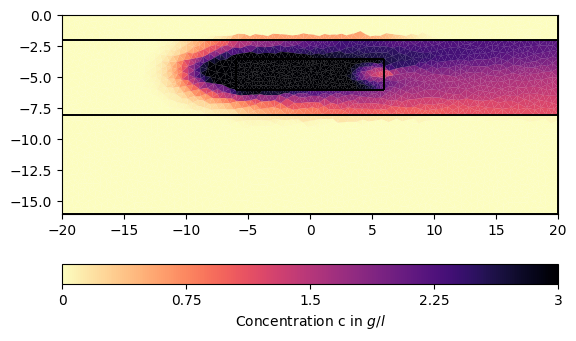

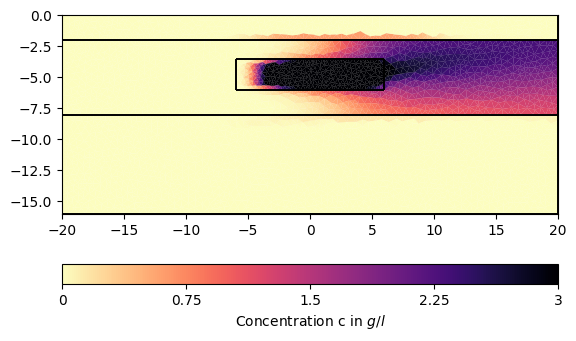

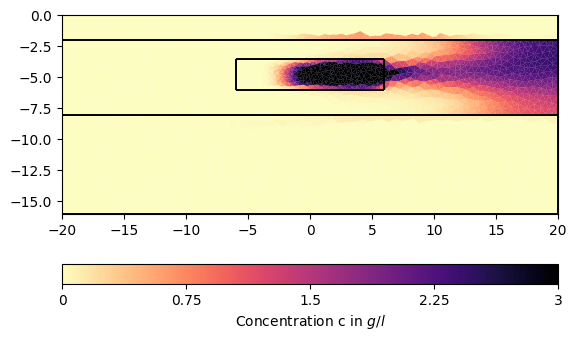

In [8]:
# Choose 800 time steps for 6 days in seconds
t = pg.utils.grange(0, 6 * 24 * 3600, n=800)

# Create dispersitivity, depending on the absolute velocity
dispersion = pg.abs(vel) * 1e-2

# Solve for injection time, but we need velocities on cell nodes
veln = mt.cellDataToNodeData(mesh, vel)
c1 = pg.solver.solveFiniteVolume(mesh, a=dispersion, f=S, vel=veln, times=t,
                                 scheme='PS', verbose=0)

# Solve without injection starting with last result
c2 = pg.solver.solveFiniteVolume(mesh, a=dispersion, f=0, vel=veln, u0=c1[-1],
                                 times=t, scheme='PS', verbose=0)
# Stack results together
c = np.vstack((c1, c2))

# We can now visualize the result:
for ci in c[1:][::200]:
    pg.show(mesh, data=ci * 0.001, cMin=0, cMax=3, cMap="magma_r",
            label="Concentration c in $g/l$")

Simulate time-lapse electrical resistivity measurements.

Create a dipole-dipole measurement scheme and a suitable mesh for ERT forward
simulations.



06/09/23 - 21:38:20 - pyGIMLi - WARNING - createERTData had been renamed to createData and will be removed in: 1.3


(<Axes: >, None)

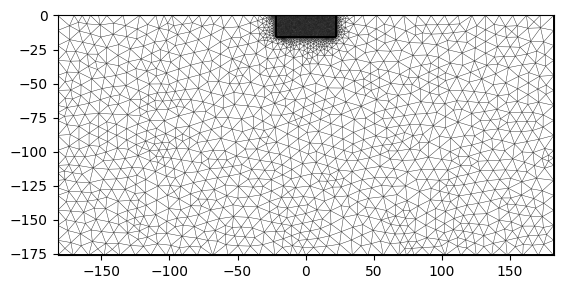

In [9]:
ertScheme = ert.createERTData(pg.utils.grange(-20, 20, dx=1.0), schemeName='dd')

meshERT = mt.createParaMesh(ertScheme, quality=33, paraMaxCellSize=0.2,
                            boundaryMaxCellSize=50, smooth=[1, 2])
pg.show(meshERT)

Use simulated concentrations to calculate bulk resistivity using Archie's Law
and fill matrix with apparent resistivity ratios with respect to a background
model:



In [10]:
# Select 10 time frame to simulate ERT data
timesERT = pg.IVector(np.floor(np.linspace(0, len(c) - 1, 10)))

# Create conductivity of fluid for salt concentration $c$
sigmaFluid = c[timesERT] * 0.1 + 0.01

# Calculate bulk resistivity based on Archie's Law
resBulk = petro.resistivityArchie(rFluid=1. / sigmaFluid, porosity=0.3, m=1.3,
                                  mesh=mesh, meshI=meshERT, fill=1)

# apply background resistivity model
rho0 = np.zeros(meshERT.cellCount()) + 1000.
for c in meshERT.cells():
    if c.center()[1] < -8:
        rho0[c.id()] = 150.
    elif c.center()[1] < -2:
        rho0[c.id()] = 500.
resis = pg.Matrix(resBulk)
for i, rbI in enumerate(resBulk):
    resis[i] = 1. / ((1. / rbI) + 1. / rho0)

Initialize and call the ERT manager for electrical simulation:



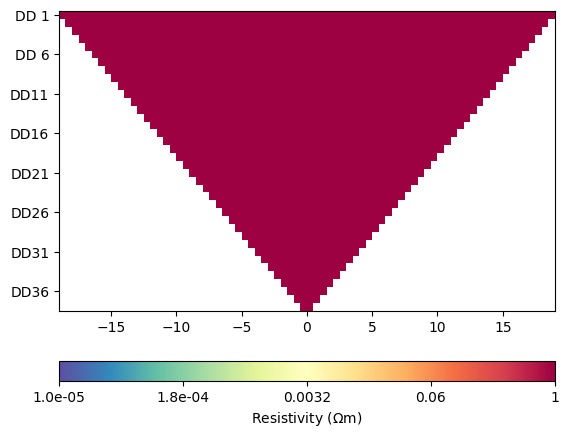

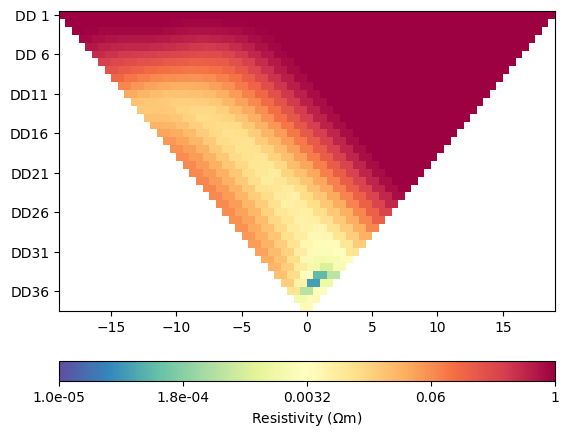

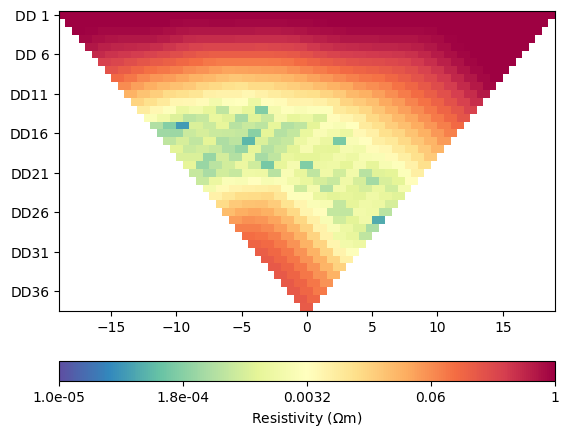

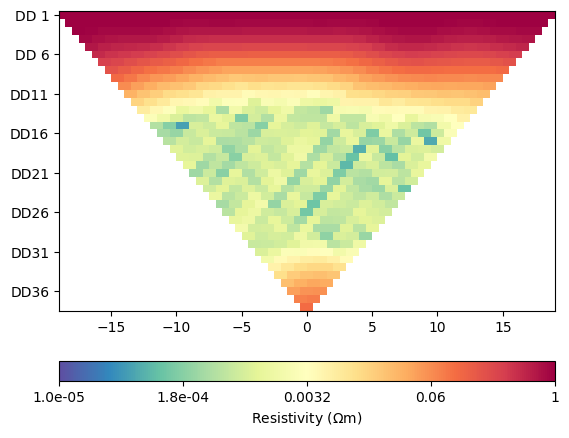

In [11]:
ERT = ERTManager(verbose=False)
# Run  simulation for  the apparent resistivities
rhoa = ERT.simulate(meshERT, res=resis, scheme=ertScheme, 
                    returnArray=True, verbose=False)

for i in range(4):
    ERT.showData(ertScheme, vals=rhoa[i]/rhoa[0], cMin=1e-5, cMax=1)